In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

pd.set_option('display.max_columns', 1000, 'display.max_colwidth', 1000, 'display.max_rows',1000)
import warnings
warnings.filterwarnings('ignore')

# Stocks

In [2]:
def convert_date(x,h, m):
    # convert items to datetime format
    x = str.split(x,sep='-')
    x = [int(item) for item in x]
    date = datetime(year=x[0],month=x[1],day=x[2],hour=h, minute=m, second=0)
    return date

def stockDirection(x, pct=10):
    # determine stock direction (increase, decrease or no change) based on percent change in stock price)
    # increase is 2, decrease is 0, remaining constant (+-pct) is 1
    if x<-pct:
        return 0
    elif x>pct:
        return 2
    else:
        return 1

def read_stocks_data_header(filename,read_lines=3):
    # Stocks Data is in UTC
    # generate header from the file
    with open(filename) as myfile:
        head1 =[]
        for i in range (0,read_lines):
            head1.append([str.split(next(myfile).strip(),sep=',') for x in range(0,1)])

    line1 = head1[0][0]
    line2 = head1[1][0]
    line3 = head1[2][0]

    header = [j.replace('^','')+' '+i+k for i, j,k in zip(line1, line2, line3)]
    header = [item.replace(' ','') for item in header]
    return header

def stock_direction(df,pp):
    # function to take stocks dataframe to generate stock change and then stock direction for all stocks
    cols = list(df.columns)
    print(cols)
    cols = [i for i in cols if 'date' not in str.lower(i)]
    for col in cols:
        if str.lower(pp)=='open':
            col_r = str(col).replace('Open','Delta')
        elif str.lower(pp)=='close':
            col_r = str(col).replace('Close','Delta')
        df[col_r] = df[col].dropna().diff()/df[col].dropna().shift(-1)*100

        if str.lower(pp)=='open':
            col_rr = str(col).replace('Open','Direction',)
        elif str.lower(pp)=='close':
            col_rr = str(col).replace('Close','Direction')
        df[col_rr] = df[col_r].dropna().apply(lambda row: stockDirection(row, pct=0)) # change the pct value to generate the three classes
    return df

def read_stocks_data(filename,header,skiprows):
    # read stocks data from file with given header
    # data from yahoo finance
    df = pd.read_csv(filename,names=header,skiprows=skiprows)
    df['Date']=pd.to_datetime(df.Datetime)
    df['Date']=df.Date.apply(lambda row:row.replace(tzinfo=None))
    
    colofinterest= ['Date']+[col for col in df.columns if 'Open' in col] + [col for col in df.columns if 'Close' in col]
    df=df[colofinterest]
    df.drop_duplicates(subset='Date', inplace=True)

    open_col = ([col for col in df.columns if 'Open' in col])
    open_col.append('Date')
    df_open = df[open_col]

    close_col = [col for col in df.columns if 'Close' in col]
    close_col.append('Date')
    df_close = df[close_col]

    df_open_1 = stock_direction(df_open,pp='open')
    df_close_1 = stock_direction(df_close,pp='close')
    return df_open_1, df_close_1

In [3]:
# Stocks Data Transformations
filename='data/^GSPC CL=F ^IXIC ^GSPTSE TSLA BTC-USD _15m.csv'
header = read_stocks_data_header(filename)
df_stocks_open, df_stocks_close = read_stocks_data(filename,header,3)
df_stocks_open['Date'] = df_stocks_open.Date.apply(lambda row: row-timedelta(hours=5)) #change time to EST
df_stocks_close['Date'] = df_stocks_open.Date.apply(lambda row: row-timedelta(hours=5)) #change time to EST
df_stocks_open.head(10)

['BTC-USDOpen', 'CL=FOpen', 'TSLAOpen', 'GSPCOpen', 'GSPTSEOpen', 'IXICOpen', 'Date']
['BTC-USDAdjClose', 'CL=FAdjClose', 'TSLAAdjClose', 'GSPCAdjClose', 'GSPTSEAdjClose', 'IXICAdjClose', 'BTC-USDClose', 'CL=FClose', 'TSLAClose', 'GSPCClose', 'GSPTSEClose', 'IXICClose', 'Date']


,BTC-USDOpen,CL=FOpen,TSLAOpen,GSPCOpen,GSPTSEOpen,IXICOpen,Date,BTC-USDDelta,BTC-USDDirection,CL=FDelta,CL=FDirection,TSLADelta,TSLADirection,GSPCDelta,GSPCDirection,GSPTSEDelta,GSPTSEDirection,IXICDelta,IXICDirection
0,36714.597656,85.330002,NaN,NaN,NaN,NaN,2022-01-25 20:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36737.652344,85.269997,NaN,NaN,NaN,NaN,2022-01-25 20:45:00,0.062510,2.0,-0.070387,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36881.648438,85.250000,NaN,NaN,NaN,NaN,2022-01-25 21:00:00,0.389300,2.0,-0.023424,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36988.496094,85.370003,NaN,NaN,NaN,NaN,2022-01-25 21:15:00,0.289300,2.0,0.140584,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36933.144531,85.360001,NaN,NaN,NaN,NaN,2022-01-25 21:30:00,-0.150004,0.0,-0.011730,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,36900.101562,85.269997,NaN,NaN,NaN,NaN,2022-01-25 21:45:00,-0.089631,0.0,-0.105763,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,36865.730469,85.099998,NaN,NaN,NaN,NaN,2022-01-25 22:00:00,-0.092881,0.0,-0.199692,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,37005.496094,85.129997,NaN,NaN,NaN,NaN,2022-01-25 22:15:00,0.376253,2.0,0.035268,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,37146.734375,85.059998,NaN,NaN,NaN,NaN,2022-01-25 22:30:00,0.377916,2.0,-0.082217,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,37372.949219,85.139999,NaN,NaN,NaN,NaN,2022-01-25 22:45:00,0.604491,2.0,0.093877,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='Count'>

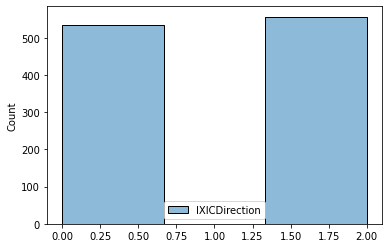

In [4]:
TARGET = ["IXICDirection"]
y = df_stocks_open[TARGET]
import seaborn as sns
sns.histplot(data=y, bins=3)

# Generate a List of Dates

In [5]:
start='2022-01-01'
end='2022-03-26'

In [6]:
# Date Range
df_date= pd.DataFrame()
df_date['Date'] = pd.bdate_range(start=start, end=end, freq='min')
df_date

,Date
0,2022-01-01 00:00:00
1,2022-01-01 00:01:00
2,2022-01-01 00:02:00
3,2022-01-01 00:03:00
4,2022-01-01 00:04:00
...,...
120956,2022-03-25 23:56:00
120957,2022-03-25 23:57:00
120958,2022-03-25 23:58:00
120959,2022-03-25 23:59:00


# Tweets Data Processing

## Tweet Read

In [7]:
# To clean up texts
import re
import nltk
# nltk.download() Download nltk data for first time use (download all packages)
import nltk.data
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('omw-1.4')


In [8]:
tweets_file = 'data/News_tweets_100k.csv'
df_tweets = pd.read_csv(tweets_file)
df_tweets['Time']=pd.to_datetime(df_tweets.Time)

df_tweets['Time'] = df_tweets.Time.apply(lambda row: row-timedelta(hours=5)) # change time to EST
df_tweets.rename(columns={'Time':'tweet_date'}, inplace = True)

colofinterest = ['tweet_date','Content','RetweetNum','LikeNum','UserHandle']
df_tweets = df_tweets[colofinterest].sort_values(by='tweet_date',ascending=True).reset_index(drop=True)
print(df_tweets.shape)

df_tweets = df_tweets[(df_tweets.tweet_date >= start) & (df_tweets.tweet_date <= end)] # filter data based on dates

(102683, 5)


## Tweet Cleaning

In [9]:
def sentence_to_wordlist(sentence, remove_stopwords=False):
    # 0. remove mentions(@), Hashtag(#)
    sentence = re.sub(r'@[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'#[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'RT[^\s]+', '', sentence,flags=re.MULTILINE )
    # 1. drop http
    p1=re.compile(r'http?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 2. drop https
    p1=re.compile(r'https?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 3. Remove non-letters
    sentence = re.sub(r'[^\w\s]','', sentence)
    # 4. Remove all numbers
    sentence = re.sub(r'[0-9]+', '', sentence)
    # 5. Convert words to lower case and split them
    sentence = sentence.lower().split()
    # Remove Stop Words
    # sentence = [word for word in sentence if not word in stop_words]
    # 5. Stemming
    # sentence = [stemmer.stem(w) for w in sentence] 
    # 6. Lemmatizing
    sentence = [lemmatizer.lemmatize(word) for word in sentence]

    #check if returned sentence is blank
    if len(sentence)==0:
      return np.nan
    else:
      # 7. Return a sentence of words
      sentence_r = ''
      for word in sentence:
        sentence_r = sentence_r + ' ' + word
      return(sentence_r)

In [10]:
# create a new column 
df_tweets['Content1']= df_tweets.Content.apply(lambda row: sentence_to_wordlist(row))
df_tweets.dropna(how='any', inplace=True)
df_tweets=df_tweets[df_tweets.UserHandle != 'CNBC']
df_tweets.reset_index(drop=True, inplace=True,)
# df_tweets.head()

In [12]:
# Get US holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2021-06-01', end='2022-12-31').to_pydatetime()
holiday_date = []
for days in holidays:
    holiday_date.append(days.date())


def IsHoliday(x,holiday_date):
    #check weekend or US holiday
    # date = x.date()
    weekday = x.weekday()
    if (x in holiday_date) | (weekday==5) | (weekday==6):
        return True #it is holiday
    else:
        return False #it is not holiday


def IsAfterMkt(x):
    #during market or after market
    x = x.time()
    starttime = datetime.strptime('9:30:00','%H:%M:%S').time()
    endtime = datetime.strptime('16:00:00','%H:%M:%S').time()
    if ((x >= starttime) & (x<=endtime)):
         return False
    else:
        return True

def IsSameDay(x):
    # Same day or next day
    x = x.time()
    samedaystarttime = datetime.strptime('00:00:00','%H:%M:%S').time()
    samedayndtime = datetime.strptime('16:00:00','%H:%M:%S').time()
    if ((x >= samedaystarttime) & (x <= samedayndtime)):
        return True
    else:
        return False



def edit_date(x):
    # transform date to correspond to stock market open or close   
    date = x.date()
    time = x.time()

    if (IsAfterMkt(x)==True) & (IsSameDay(x)==False):
        time=datetime.strptime('9:30:00','%H:%M:%S').time()
        date=date+timedelta(days=1)
    elif ((IsAfterMkt(x)==True) & (IsSameDay(x)==True)):
        date=date
        time=time=datetime.strptime('9:30:00','%H:%M:%S').time()
    
    while IsHoliday(date,holiday_date) ==1:
        date = date+timedelta(days=1)

    date_time = str(date)+ ' '+ str(time)
    date_time = datetime.strptime(date_time, "%Y-%m-%d %H:%M:%S")
    return date_time

# Code for checking logic
# colofinterest=['tweet_date','tweet_day','Date','Day']
# df_tweets[colofinterest].iloc[85:300]

In [13]:
# Change tweet date to corresponding market open date and time
df_tweets['tweet_day'] = df_tweets.tweet_date.apply(lambda row:row.date().strftime("%A"))
df_tweets['Date'] = df_tweets.tweet_date.apply(lambda row:edit_date(row))
df_tweets['Day'] = df_tweets.Date.apply(lambda row:row.date().strftime("%A"))
df_tweets['Date'] = df_tweets.Date.dt.round('15min') #round to the nearest 15 minute
df_tweets.head(1)

,tweet_date,Content,RetweetNum,LikeNum,UserHandle,Content1,tweet_day,Date,Day
0,2022-01-01 00:00:03+00:00,"WATCH: Here’s a roundup of 2021 in numbers, featuring Elon Musk, meme-stocks and crypto https://t.co/8B1arJU1qT",2,11,ReutersBiz,watch here a roundup of in number featuring elon musk memestocks and crypto,Saturday,2022-01-03 09:30:00,Monday


In [14]:
# create a new column 
import swifter
df_tweets['Content1']= df_tweets.Content.apply(lambda row: sentence_to_wordlist(row))
df_tweets.dropna(how='any', inplace=True)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33233 entries, 0 to 33232
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweet_date  33233 non-null  datetime64[ns, UTC]
 1   Content     33233 non-null  object             
 2   RetweetNum  33233 non-null  int64              
 3   LikeNum     33233 non-null  int64              
 4   UserHandle  33233 non-null  object             
 5   Content1    33233 non-null  object             
 6   tweet_day   33233 non-null  object             
 7   Date        33233 non-null  datetime64[ns]     
 8   Day         33233 non-null  object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(2), object(5)
memory usage: 2.3+ MB


# Tweet Sentiments

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

def polarityScore(a, col):
    # Create a column for score
    a['score'] = a[col].swifter.apply(lambda row: calculate_polarity_scores(row))
    #split all the scores into separate columns
    # columns = ['negative', 'neutral', 'positive', 'compound'])
    a['negative']=a.score.apply(lambda x: x[0])
    a['neutral']=a.score.apply(lambda x: x[1])
    a['positive']=a.score.apply(lambda x: x[2])
    a['combined']=a.score.apply(lambda x: x[3])
    return a

def calculate_polarity_scores(x):
    # use VADER to get polarity of tweets
    sid = SentimentIntensityAnalyzer()
    score = sid.polarity_scores(x)
    score_list = []
    for i in score.values():
        score_list.append(i)
    return score_list

In [16]:
df_tweets = polarityScore(df_tweets, 'Content1')

# sns.histplot(data=result, x='compound')
# df_tweets.head()

Pandas Apply: 100%|██████████| 33233/33233 [03:47<00:00, 146.39it/s]


# Merge

In [17]:
df = pd.merge(df_date,df_stocks_open,how='inner', on='Date')
df = pd.merge(df, df_tweets, how='inner', on='Date')
len(df)
#df = df.dropna().reset_index(drop=True)
# df.head()

30491

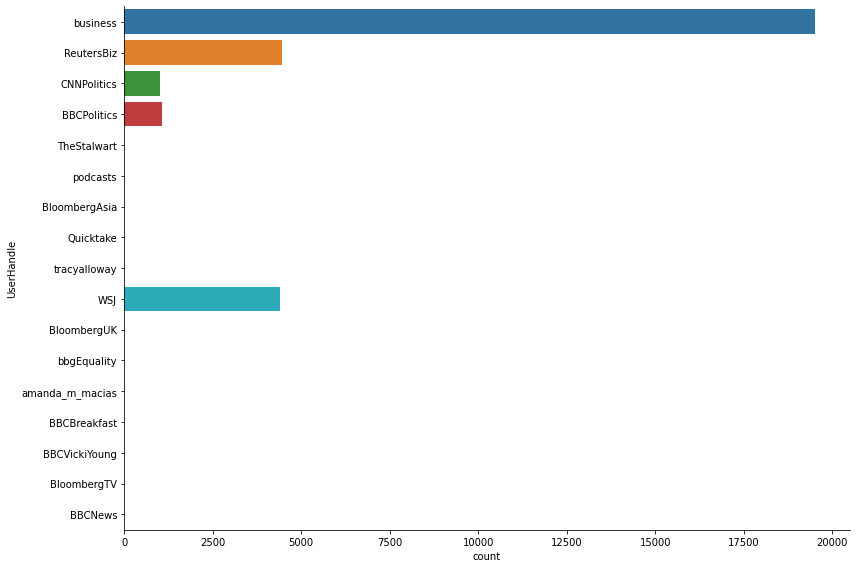

In [23]:
import seaborn as sns
plt = sns.catplot(y='UserHandle', kind='count', data=df, height=8, aspect=1.5, palette="tab10")

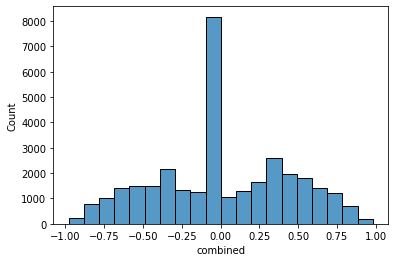

In [28]:
plt = sns.histplot(data=df_tweets, x='combined',bins=20)

In [21]:
df.columns

Index(['Date', 'BTC-USDOpen', 'CL=FOpen', 'TSLAOpen', 'GSPCOpen', 'GSPTSEOpen',
       'IXICOpen', 'BTC-USDDelta', 'BTC-USDDirection', 'CL=FDelta',
       'CL=FDirection', 'TSLADelta', 'TSLADirection', 'GSPCDelta',
       'GSPCDirection', 'GSPTSEDelta', 'GSPTSEDirection', 'IXICDelta',
       'IXICDirection', 'tweet_date', 'Content', 'RetweetNum', 'LikeNum',
       'UserHandle', 'Content1', 'tweet_day', 'Day', 'score', 'negative',
       'neutral', 'positive', 'combined'],
      dtype='object')

# EDA

<AxesSubplot:xlabel='CL=FDirection', ylabel='Count'>

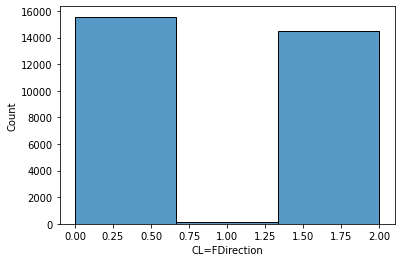

In [22]:
sns.histplot(data=df, x='CL=FDirection',bins=3)

In [23]:
df.groupby(['CL=FDirection'], as_index=False).agg(
    {
        'combined':['count','mean','var'],
        'negative':['count','mean','var'],
        'neutral':['count','mean','var'],
        'positive':['count','mean','var'],
    }
)

CL=FDirection combined                     negative                      \
                   count      mean       var    count      mean       var   
0           0.0    15568  0.023970  0.185556    15568  0.080386  0.010474   
1           1.0      161  0.081553  0.172075      161  0.072311  0.010311   
2           2.0    14469  0.007862  0.186697    14469  0.084468  0.010969   

  neutral                     positive                      
    count      mean       var    count      mean       var  
0   15568  0.827110  0.017418    15568  0.092503  0.010719  
1     161  0.827578  0.017415      161  0.100106  0.010823  
2   14469  0.824705  0.017311    14469  0.090830  0.010332

<AxesSubplot:xlabel='GSPCDirection', ylabel='Count'>

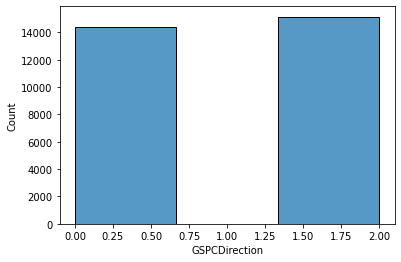

In [24]:
sns.histplot(data=df, x='GSPCDirection',bins=3)

In [25]:
df.groupby(['GSPCDirection'], as_index=False).agg(
    {
        'combined':['count','mean','var'],
        'negative':['count','mean','var'],
        'neutral':['count','mean','var'],
        'positive':['count','mean','var'],
    }
)

GSPCDirection combined                     negative                      \
                   count      mean       var    count      mean       var   
0           0.0    14402  0.016342  0.184781    14402  0.082410  0.010557   
1           1.0       17 -0.083853  0.190689       17  0.073059  0.007790   
2           2.0    15154  0.015078  0.188032    15154  0.082628  0.010934   

  neutral                     positive                      
    count      mean       var    count      mean       var  
0   14402  0.825548  0.017451    14402  0.092044  0.010743  
1      17  0.865118  0.011325       17  0.061824  0.006299  
2   15154  0.826234  0.017260    15154  0.091137  0.010308

<AxesSubplot:xlabel='GSPTSEDirection', ylabel='Count'>

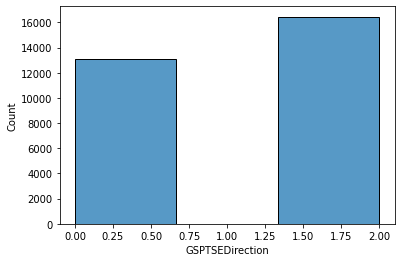

In [26]:
sns.histplot(data=df, x='GSPTSEDirection',bins=3)

In [27]:
df.groupby(['GSPTSEDirection'], as_index=False).agg(
    {
        'combined':['count','mean','var'],
        'negative':['count','mean','var'],
        'neutral':['count','mean','var'],
        'positive':['count','mean','var'],
    }
)

GSPTSEDirection combined                     negative                      \
                     count      mean       var    count      mean       var   
0             0.0    13111  0.016059  0.185182    13111  0.082456  0.010704   
1             1.0        7  0.075243  0.193300        7  0.046429  0.001930   
2             2.0    16455  0.015275  0.187467    16455  0.082580  0.010787   

  neutral                     positive                      
    count      mean       var    count      mean       var  
0   13111  0.825632  0.017746    13111  0.091914  0.010777  
1       7  0.893000  0.005564        7  0.060429  0.006233  
2   16455  0.826125  0.017039    16455  0.091295  0.010314

<AxesSubplot:xlabel='IXICDirection', ylabel='Count'>

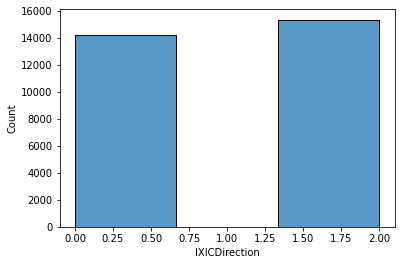

In [28]:
sns.histplot(data=df, x='IXICDirection',bins=3)

In [29]:
df.groupby(['IXICDirection'], as_index=False).agg(
    {
        'combined':['count','mean','var'],
        'negative':['count','mean','var'],
        'neutral':['count','mean','var'],
        'positive':['count','mean','var'],
    }
)

IXICDirection combined                     negative                      \
                   count      mean       var    count      mean       var   
0           0.0    14237  0.012768  0.185581    14237  0.082601  0.010585   
1           2.0    15336  0.018299  0.187242    15336  0.082438  0.010900   

  neutral                     positive                      
    count      mean       var    count      mean       var  
0   14237  0.826375  0.017370    14237  0.091025  0.010547  
1   15336  0.825503  0.017332    15336  0.092060  0.010491

# Last Step - Export Data

In [31]:
def applysentiment(x):
    if x<0:
        return 0
    elif x>0:
        return 2
    else:
        return 1

df['sentiment'] = df.combined.apply(lambda x: applysentiment(x))
df.columns

Index(['Date', 'BTC-USDOpen', 'CL=FOpen', 'TSLAOpen', 'GSPCOpen', 'GSPTSEOpen',
       'IXICOpen', 'BTC-USDDelta', 'BTC-USDDirection', 'CL=FDelta',
       'CL=FDirection', 'TSLADelta', 'TSLADirection', 'GSPCDelta',
       'GSPCDirection', 'GSPTSEDelta', 'GSPTSEDirection', 'IXICDelta',
       'IXICDirection', 'tweet_date', 'Content', 'RetweetNum', 'LikeNum',
       'UserHandle', 'Content1', 'tweet_day', 'Day', 'score', 'negative',
       'neutral', 'positive', 'combined', 'sentiment'],
      dtype='object')

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

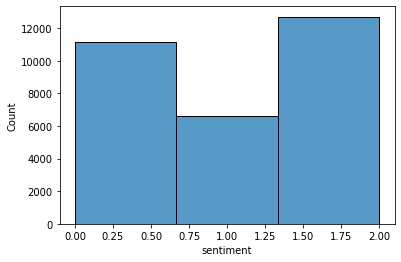

In [32]:
sns.histplot(data=df, x='sentiment',bins=3)

In [34]:
# Export df
df.to_csv('data/df_raw.csv', index=False)

In [33]:
df_final = df.groupby(['Date'], as_index=False).agg(
    {
        'combined':['count','mean','var'],
        'negative':['count','mean','var'],
        'neutral':['count','mean','var'],
        'positive':['count','mean','var'],
        'CL=FDirection':['mean'],
        'GSPCDirection':['mean'],
        'GSPTSEDirection':['mean'],
        'IXICDirection':['mean'],
        'BTC-USDDirection':['mean'],
        'TSLADirection':['mean'],
        'sentiment':['mean'],
    }
).reset_index(drop=True)

df_final.to_csv('data/news_tweets_sentiments.csv',index=False, header=True)


In [35]:
df.groupby(['Date'])[['combined','negative','neutral','positive','CL=FDirection','GSPCDirection','GSPTSEDirection','IXICDirection']]\
    .mean().reset_index(drop=True)

    # .to_csv('data/finaldata.csv',index=False, header=True)

,combined,negative,neutral,positive,CL=FDirection,GSPCDirection,GSPTSEDirection,IXICDirection
0,0.048937,0.070012,0.833555,0.096448,0.0,NaN,NaN,NaN
1,0.091173,0.040909,0.839000,0.120091,2.0,0.0,0.0,0.0
2,-0.026320,0.081600,0.836000,0.082400,2.0,2.0,2.0,2.0
3,0.317771,0.064857,0.721000,0.214000,0.0,0.0,2.0,2.0
4,-0.201950,0.134250,0.824750,0.041000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1128,-0.067250,0.154167,0.685500,0.160333,0.0,NaN,NaN,NaN
1129,-0.263600,0.084750,0.896500,0.018750,0.0,NaN,NaN,NaN
1130,-0.159411,0.088444,0.850889,0.060667,0.0,NaN,NaN,NaN
1131,0.016886,0.070429,0.843143,0.086286,NaN,NaN,NaN,NaN


In [28]:
#df.groupby(['Date'])[['combined','negative','neutral','positive','inc/dec']].mean().reset_index(drop=True)

In [29]:
#df[['Date','Content','Content1','combined','negative','neutral','positive','inc/dec']].to_csv('data/results.csv',index=False, sep=',')